# Import and constant

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from keras.models import Model
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.applications import resnet
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
import face_recognition

In [2]:
h = 128
w = 100
img_shape = (h, w, 3)
batch_size = 16

# Preprocess data

In [3]:
df = pd.read_csv('data.csv', index_col=0)
df

,anchor_path,positive_path,negative_path
0,face_images/Aaron_Peirsol/Aaron_Peirsol_0001.jpg,face_images/Aaron_Peirsol/Aaron_Peirsol_0002.jpg,face_images/Jay_Rasulo/Jay_Rasulo_0002.jpg
1,face_images/Aaron_Peirsol/Aaron_Peirsol_0002.jpg,face_images/Aaron_Peirsol/Aaron_Peirsol_0004.jpg,face_images/Anne_McLellan/Anne_McLellan_0001.jpg
2,face_images/Aaron_Peirsol/Aaron_Peirsol_0003.jpg,face_images/Aaron_Peirsol/Aaron_Peirsol_0004.jpg,face_images/James_Blake/James_Blake_0010.jpg
3,face_images/Aaron_Peirsol/Aaron_Peirsol_0004.jpg,face_images/Aaron_Peirsol/Aaron_Peirsol_0003.jpg,face_images/Amanda_Beard/Amanda_Beard_0002.jpg
4,face_images/Aaron_Sorkin/Aaron_Sorkin_0001.jpg,face_images/Aaron_Sorkin/Aaron_Sorkin_0002.jpg,face_images/Oswaldo_Paya/Oswaldo_Paya_0001.jpg
...,...,...,...
9117,face_images/Zinedine_Zidane/Zinedine_Zidane_00...,face_images/Zinedine_Zidane/Zinedine_Zidane_00...,face_images/Mark_Richt/Mark_Richt_0001.jpg
9118,face_images/Zoran_Djindjic/Zoran_Djindjic_0001...,face_images/Zoran_Djindjic/Zoran_Djindjic_0002...,face_images/Roy_Moore/Roy_Moore_0003.jpg
9119,face_images/Zoran_Djindjic/Zoran_Djindjic_0002...,face_images/Zoran_Djindjic/Zoran_Djindjic_0004...,face_images/Hashim_Thaci/Hashim_Thaci_0001.jpg
9120,face_images/Zoran_Djindjic/Zoran_Djindjic_0003...,face_images/Zoran_Djindjic/Zoran_Djindjic_0004...,face_images/Adam_Sandler/Adam_Sandler_0003.jpg


In [4]:
def preprocess_image(filename):

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (h,w))
    return image


def preprocess_triplets(anchor, positive, negative):

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [5]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(df['anchor_path'])
positive_dataset = tf.data.Dataset.from_tensor_slices(df['positive_path'])
negative_dataset = tf.data.Dataset.from_tensor_slices(df['negative_path'])

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

train_dataset = dataset.take(round(df.shape[0] * 0.9))
val_dataset = dataset.skip(round(df.shape[0] * 0.9))

train_dataset = train_dataset.batch(batch_size, drop_remainder=False)
train_dataset = train_dataset.prefetch(4)

val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
val_dataset = val_dataset.prefetch(4)

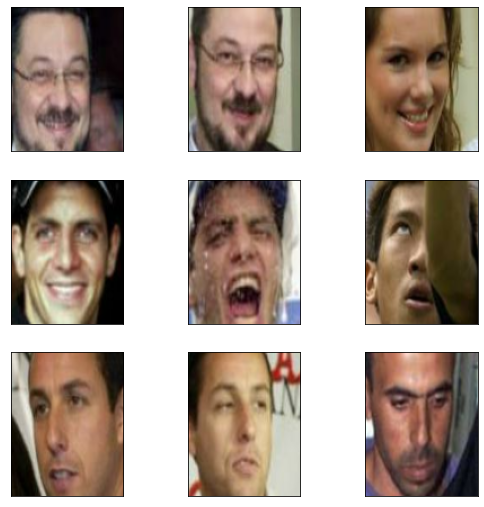

In [6]:
def visualize(anchor, positive, negative):


    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

# Build Model

In [7]:
base_cnn = keras.applications.ResNet50(
    weights="imagenet", input_shape=(h,w,3), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable
base_cnn.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 50, 64)   256         ['conv1_conv[0][0]']      

In [8]:
class DistanceLayer(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=(h,w,3))
positive_input = layers.Input(name="positive", shape=(h,w,3))
negative_input = layers.Input(name="negative", shape=(h,w,3))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [9]:
class SiameseModel(Model):

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [11]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5
514/514 [==============================] - 142s 263ms/step - loss: 0.3550 - val_loss: 0.3383
Epoch 2/5
514/514 [==============================] - 125s 242ms/step - loss: 0.3413 - val_loss: 0.3115
Epoch 3/5
514/514 [==============================] - 125s 242ms/step - loss: 0.3040 - val_loss: 0.3131
Epoch 4/5
514/514 [==============================] - 125s 243ms/step - loss: 0.2792 - val_loss: 0.2992
Epoch 5/5
514/514 [==============================] - 125s 243ms/step - loss: 0.2626 - val_loss: 0.2558


In [12]:
keras.models.save_model(embedding, 'embedding_for_siamese_model')

INFO:tensorflow:Assets written to: embedding_for_siamese_model\assets


C:\Users\WorkStation\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\WorkStation\anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


# Results

Positive RMSE: 0.053010166
Negative RMSE 0.06321303 



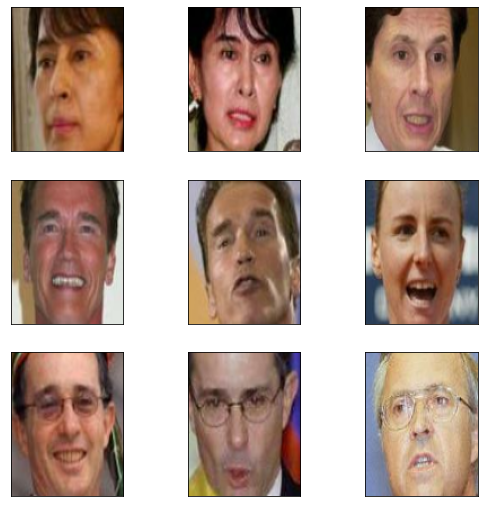

In [90]:

sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)
cosine_similarity = metrics.CosineSimilarity()
mse = metrics.RootMeanSquaredError()

#     cos_positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
#     print("Positive similarity:", cos_positive_similarity.numpy())

#     cos_negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
#     print("Negative similarity", cos_negative_similarity.numpy())

mse_positive_similarity = mse(anchor_embedding, positive_embedding)
print("Positive RMSE:", mse_positive_similarity.numpy())

mse_negative_similarity = mse(anchor_embedding, negative_embedding)
print("Negative RMSE", mse_negative_similarity.numpy(), '\n')

In [96]:
pos = []
neg = []
mse = metrics.mse
for sample in val_dataset:
   
    anchor, positive, negative = sample
    anchor_embedding, positive_embedding, negative_embedding = (
        embedding(resnet.preprocess_input(anchor)),
        embedding(resnet.preprocess_input(positive)),
        embedding(resnet.preprocess_input(negative)),
    )
    cosine_similarity = metrics.CosineSimilarity()

    
#     positive_similarity = mse(anchor_embedding, positive_embedding)
#     pos.append(positive_similarity.numpy())

#     negative_similarity = mse(anchor_embedding, negative_embedding)
#     neg.append(negative_similarity.numpy())
    
    mse_positive_similarity = mse(anchor_embedding, positive_embedding)
    pos.extend(mse_positive_similarity)
#     print("Positive RMSE:", mse_positive_similarity.numpy())

    mse_negative_similarity = mse(anchor_embedding, negative_embedding)
    neg.extend(mse_negative_similarity)
#     print("Negative RMSE", mse_negative_similarity.numpy(),'\n')


mean of positives 0.002537618624046445
mean of negatives 0.00504133477807045


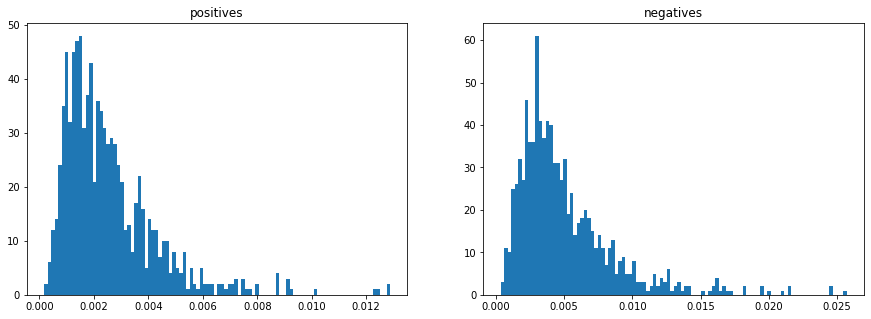

In [97]:
pos = np.asarray(pos)
neg = np.asarray(neg)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1).hist(pos, bins=100)
plt.title('positives')
plt.subplot(1,2,2).hist(neg, bins=100)
plt.title('negatives')
print(f'mean of positives {np.mean(pos)}')
print(f'mean of negatives {np.mean(neg)}')

